In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [4]:
cache_states = [n*2 for n in range(50)]

# Get temporal correlation dynamics

In [5]:
preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)

In [6]:
acts_over_time = acts_over_time.reshape((acts_over_time.shape[0], -1))

In [7]:
time_corr = np.corrcoef(acts_over_time)

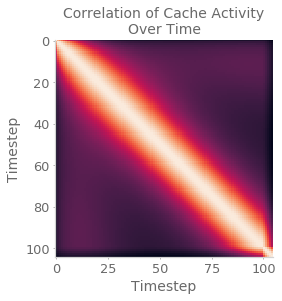

In [8]:
plt.figure()
plt.imshow(time_corr)
plt.xlabel('Timestep')
plt.ylabel('Timestep')
plt.title('Correlation of Cache Activity\nOver Time')
plt.show()

# Run Task (no learning)

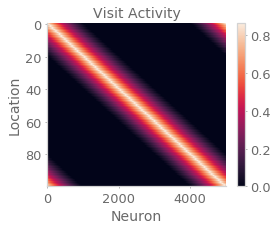

In [9]:
model.reset()
figsize=(4,3)

_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()
plt.figure(figsize=figsize)
plt.imshow(place_acts, vmin=0,  aspect='auto')
plt.xlabel("Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Visit Activity")
plt.show()

_, cache_acts, _, cache_acts_over_time = model.run_recurrent(
    place_inputs, n_zero_input=20)

# Define cache activity as a mean over some time window

In [10]:
start_t = steps-25 # Start of time window

In [11]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[start_t:steps, location, :].mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [12]:
cache_mean = avg_cache_acts.mean(axis=0)

# Fig 3ab, Fig 4: cache v. visit correlation

In [13]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}
std_scaling = 1

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(3): # More samples
            c_c_corr = nb_corr(cache_act_i, cache_act_j)
            c_v_corr = nb_corr(cache_act_i, place_act_j)
            v_v_corr = nb_corr(place_act_i, place_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)

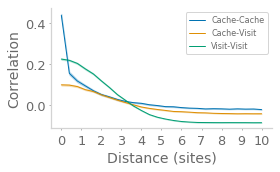

In [14]:
plt.figure(figsize=(4,2.5))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Cache', color='C0',
    data=pd.DataFrame(cache_cache_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Visit', color='C1',
    data=pd.DataFrame(cache_visit_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Visit-Visit', color='C2',
    data=pd.DataFrame(visit_visit_corr))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel('Distance (sites)')
plt.tight_layout()
plt.legend()
plt.savefig('corr_dist.png', dpi=300)
plt.show()

# Fig 3c: Example barcodes

In [15]:
noisy_avg_cache_acts = nb(avg_cache_acts, std_scaling=1.0, mu_scaling=1.0, shift=0.2)
noisy_cache_mean = np.mean(noisy_avg_cache_acts, axis=0)

In [16]:
noisy_place_acts = nb(place_acts, std_scaling=1.0, mu_scaling=1.0, shift=0.2)
noisy_place_mean = np.mean(noisy_place_acts, axis=0).flatten()
noisy_place_std = np.std(noisy_place_acts, axis=0).flatten()

In [17]:
barcodes = []
place_codes = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Cache activations
    _cache_act = noisy_avg_cache_acts[i].copy()
    _cache_act -= noisy_cache_mean
    
    # Place activations
    _place_act = noisy_place_acts[location].copy()
    _place_act -= noisy_place_mean
    _place_act /= np.linalg.norm(_place_act)
    place_codes.append(_place_act)
    
    # Define barcode
    projection = np.dot(_cache_act, _place_act) * _place_act
    barcode = _cache_act - projection
    barcodes.append(barcode)

In [18]:
dead_neurons = np.where(np.sum(np.array(place_codes)**2, axis=0) ==0)[0]
alive_neurons = np.where(np.sum(np.array(place_codes)**2, axis=0) > 0)[0]
argmaxes = np.argmax(np.array(place_codes)[:, alive_neurons], axis=0)
neuron_order = np.concatenate([dead_neurons, alive_neurons[np.argsort(argmaxes)]], axis=0)

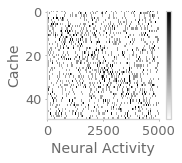

In [47]:
# Chettih et al Figure 3
x = np.array(np.array(barcodes)[:])
fig = plt.figure(figsize=(2.5,2))
im = plt.imshow(x, cmap='binary', interpolation='nearest', aspect='auto')
barcode_maxlim = np.percentile(x, 99)
plt.clim(0, barcode_maxlim)
cbar = fig.colorbar(im)
cbar.set_ticks([])
plt.ylabel('Cache')
plt.xlabel('Neural Activity')
plt.savefig('barcodes.png', dpi=300)
plt.show()

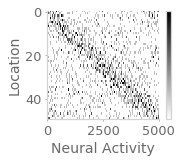

In [48]:
# Chettih et al Figure 3
x = np.array(np.array(place_codes)[:])
fig = plt.figure(figsize=(2.5,2))
im = plt.imshow(x, cmap='binary', interpolation='nearest', aspect='auto')
place_maxlim = np.percentile(x, 99)
plt.clim(0, place_maxlim)
cbar = fig.colorbar(im)
cbar.set_ticks([])
plt.ylabel('Location')
plt.xlabel('Neural Activity')
plt.savefig('place_firing.png', dpi=300)
plt.show()

# Fig 2: Barcode neuron participation

In [21]:
noisy_avg_cache_acts = nb(avg_cache_acts, std_scaling=1.0, mu_scaling=1.0, shift=0.2)
noisy_cache_mean = np.mean(noisy_avg_cache_acts, axis=0)

In [22]:
activities = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = avg_cache_acts[i].copy()
    activities.append((vec-place_mean)/(place_std))

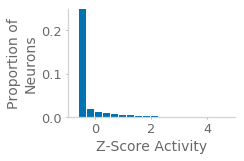

(zoomed in)


In [23]:
x = np.array(activities)
n_caches, n_neurons = x.shape
plt.figure(figsize=(3,2))
plt.hist(
    x.flatten(),
    weights=[1/x.size]*x.size, bins=70)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.xlim(-1,5)
plt.ylim(0,0.25)
plt.savefig('fr_distrib.png', dpi=300)
plt.show()
print("(zoomed in)")

/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


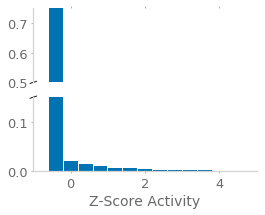

In [24]:
data = x.flatten()
weights = [1/x.size]*x.size
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 3),
                              gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.2})

# Plot the same data on both axes
ax.hist(data, weights=weights, bins=50)
ax2.hist(data, weights=weights, bins=50)

# Zoom in to different parts of the y-axis
ax.set_ylim(0.5, 0.75)  # For the top subplot
ax2.set_ylim(0, 0.15)   # For the bottom subplot
ax.set_xlim(-1, 5)
ax2.set_xlim(-1, 5)

# Hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

# Add diagonal lines to indicate the break
d = .015  # Size of the diagonal lines
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
plt.xlabel('Z-Score Activity')
plt.tight_layout()
plt.savefig('fr_distrib.png', dpi=300)
plt.show()

In [25]:
vals = []
for i in range(x.shape[1]):
    _x = x[:,i]
    p = np.sum(_x<0)/_x.size
    vals.append(p)
val = np.mean(vals)
print(f'Neurons fire under their place mean in {val*100:.2f} % of Caches')

Neurons fire under their place mean in 89.87 % of Caches


# Individual Cells

In [26]:
n_samples = 70

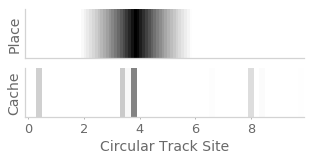

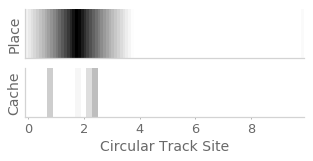

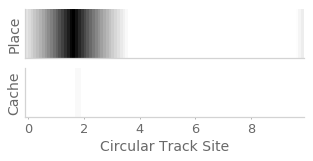

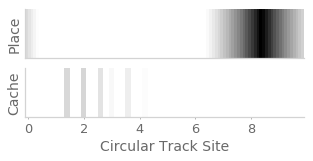

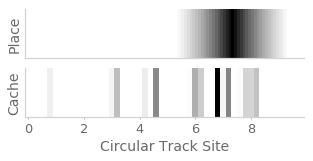

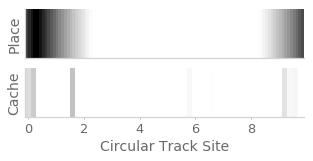

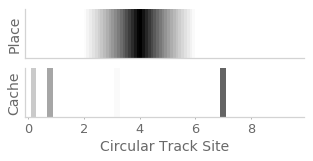

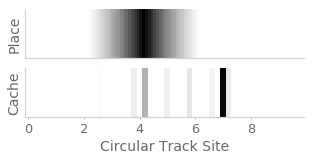

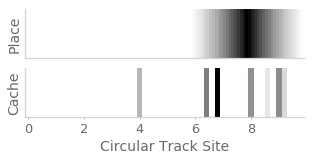

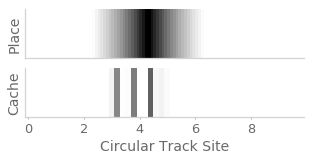

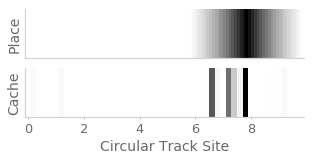

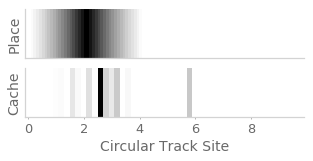

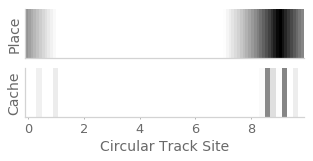

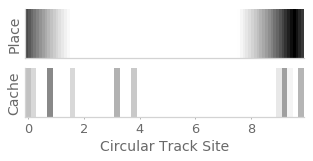

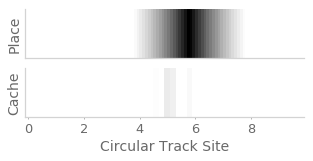

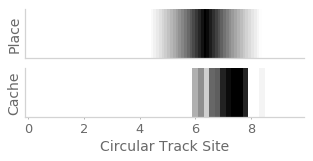

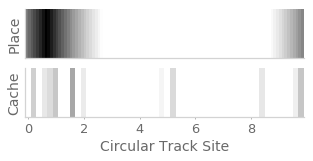

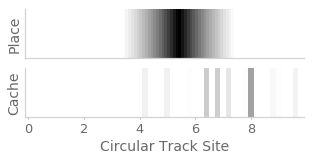

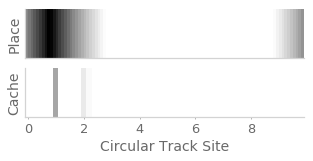

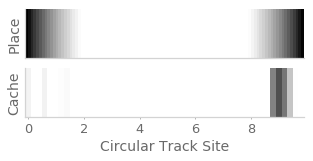

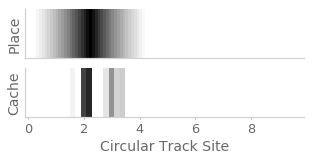

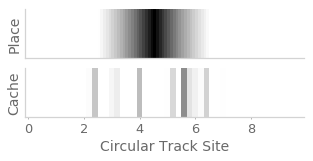

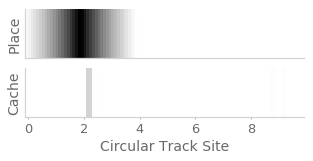

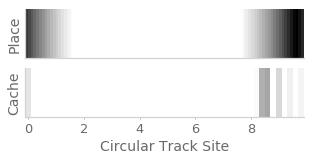

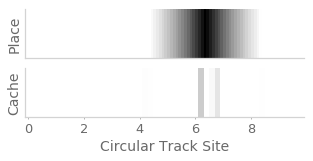

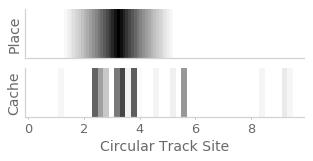

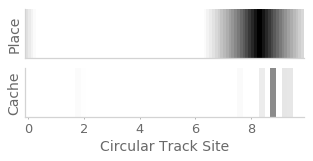

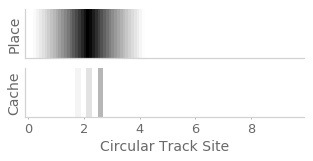

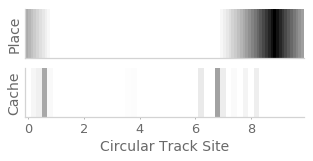

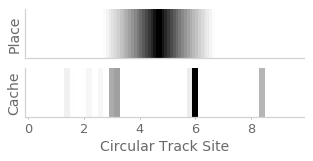

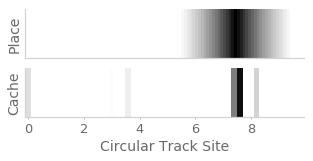

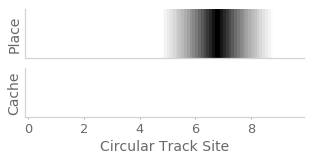

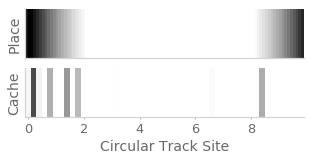

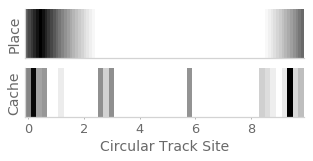

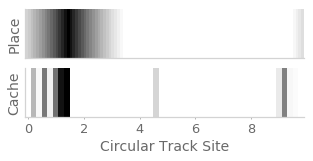

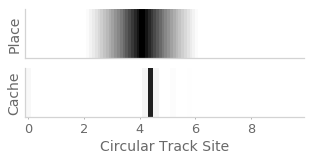

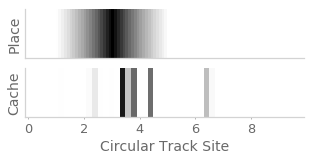

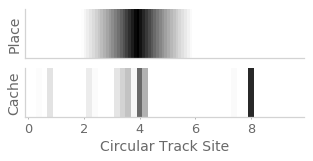

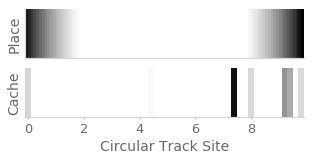

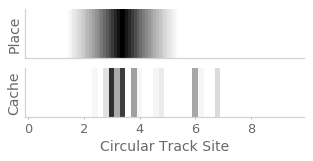

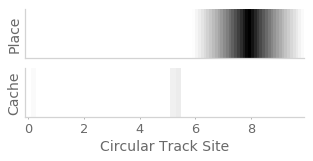

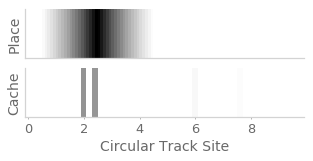

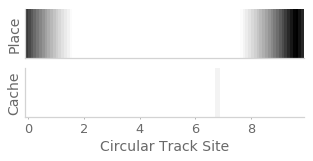

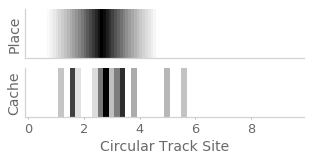

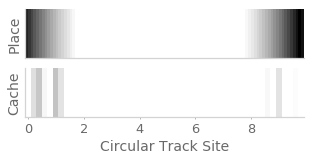

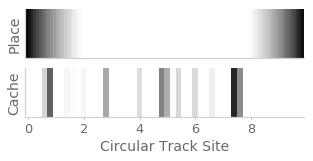

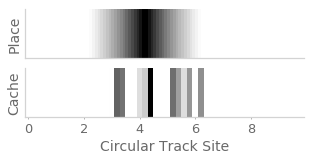

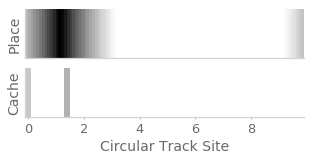

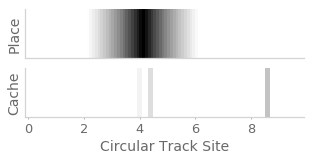

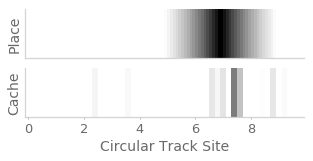

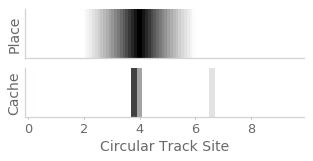

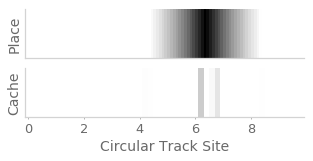

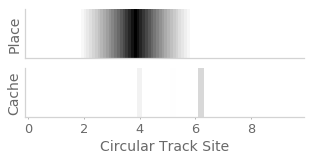

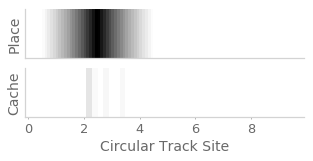

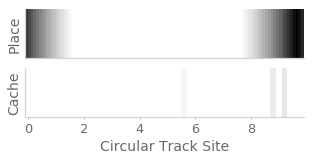

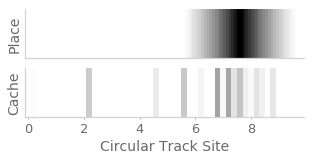

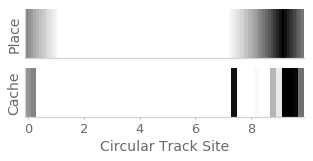

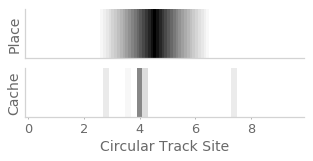

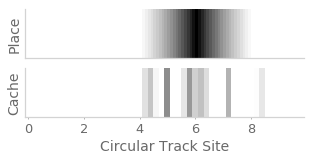

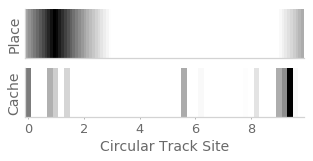

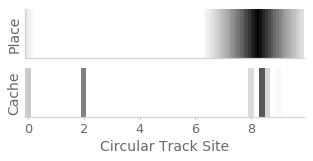

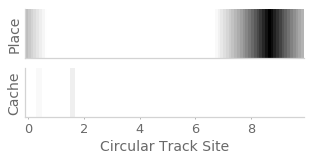

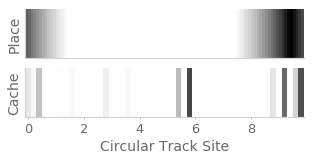

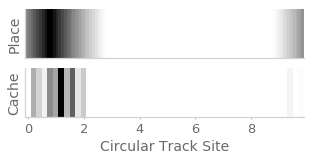

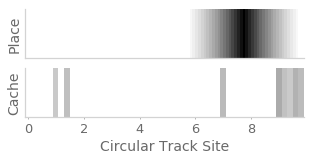

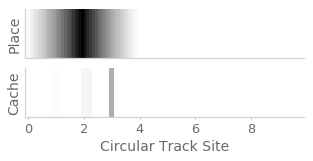

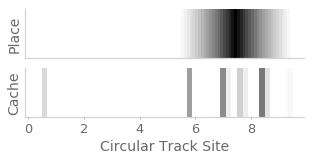

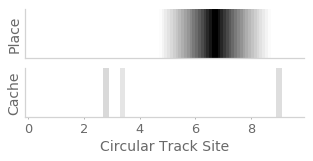

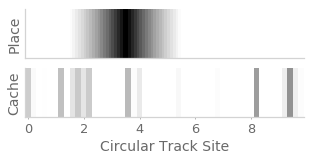

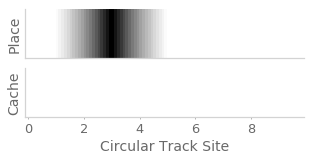

In [43]:
for _ in range(n_samples):
    idx = np.random.choice(N_bar)
    fig, axs = plt.subplots(2, 1, figsize=(5,2))
    axs[0].imshow(
        place_acts[:, idx].reshape((1,-1)),
        aspect='auto', cmap='binary')
    axs[1].imshow(
        avg_cache_acts[:,idx].reshape((1,-1)),
        aspect='auto', cmap='binary', clim=(0, barcode_maxlim))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([0, 10, 20, 30, 40])
    axs[1].set_xticklabels([0, 2, 4, 6, 8])
    axs[1].set_xlabel('Circular Track Site')
    axs[0].set_ylabel('Place')
    axs[1].set_ylabel('Cache')
    plt.show()

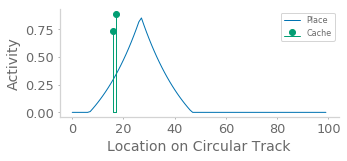

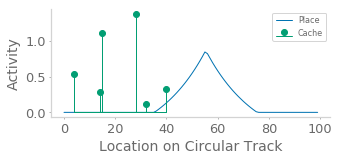

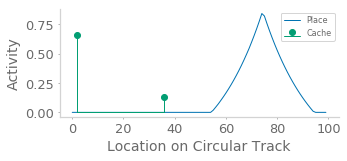

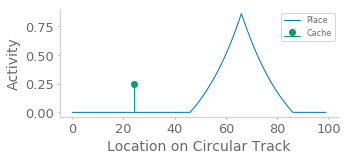

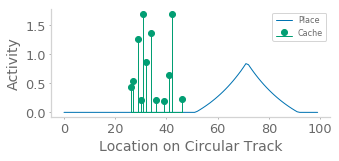

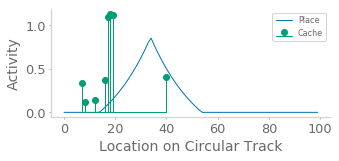

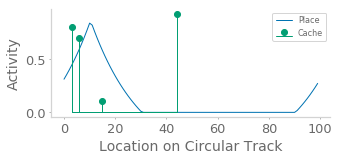

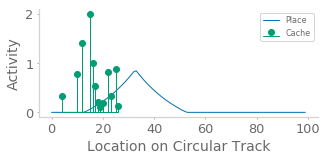

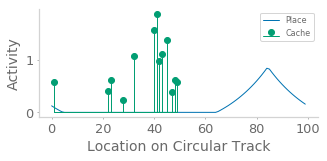

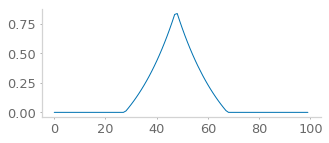

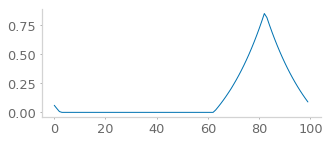

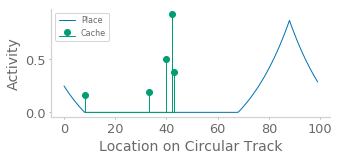

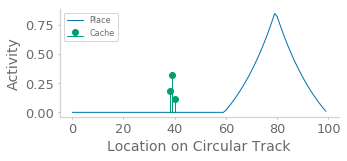

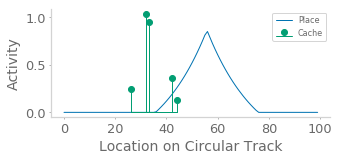

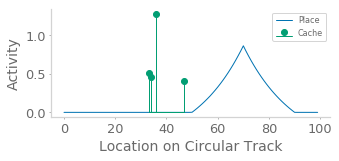

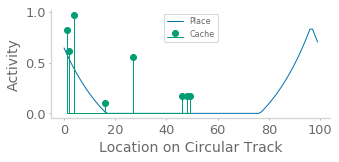

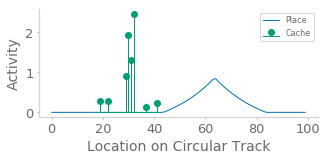

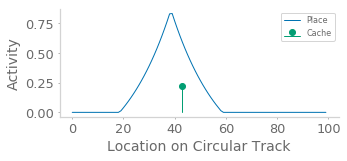

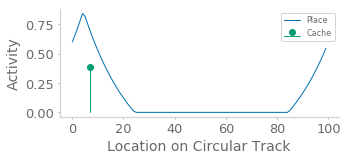

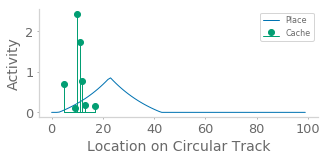

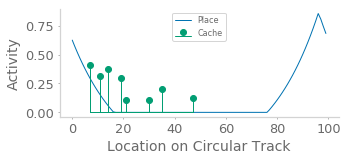

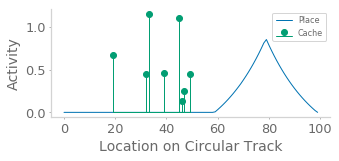

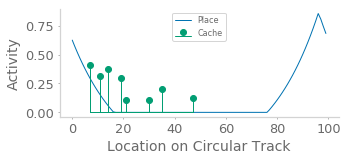

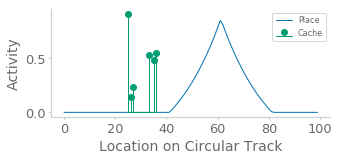

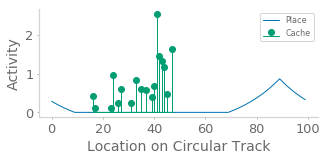

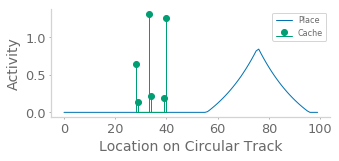

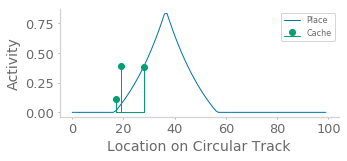

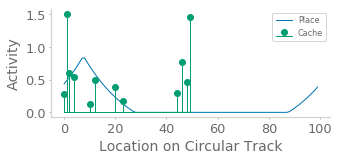

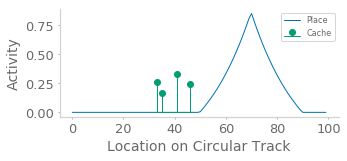

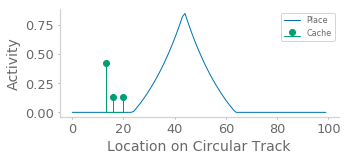

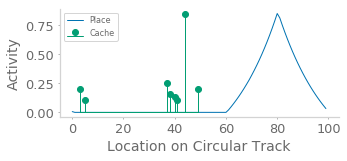

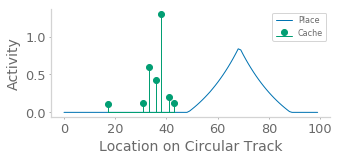

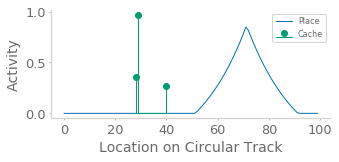

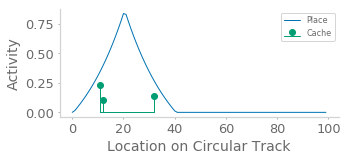

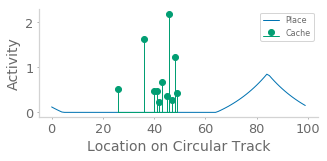

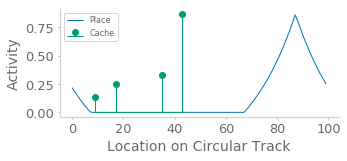

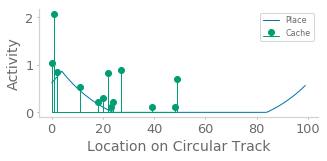

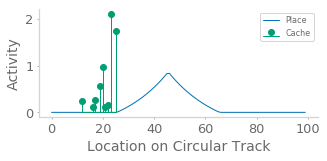

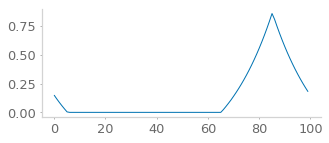

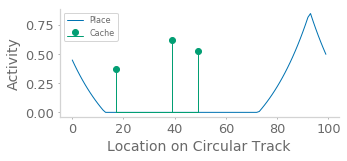

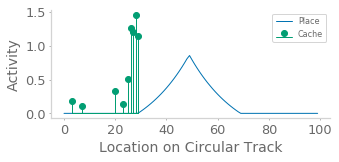

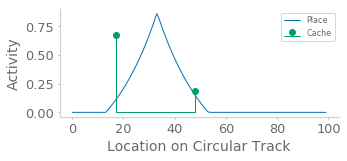

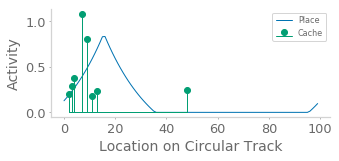

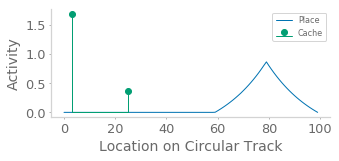

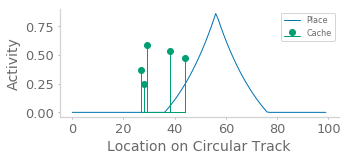

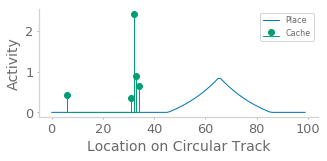

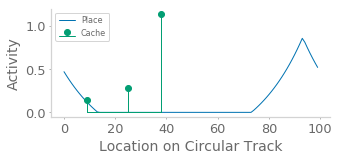

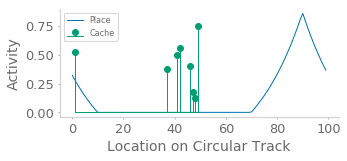

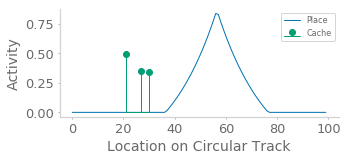

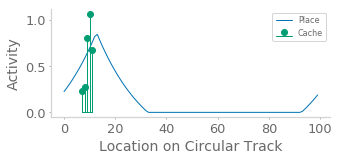

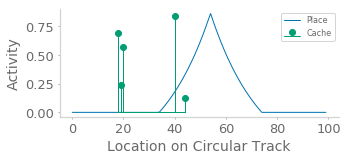

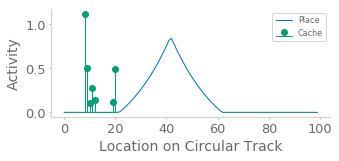

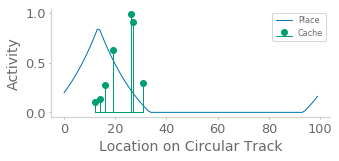

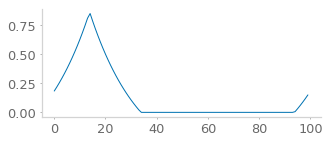

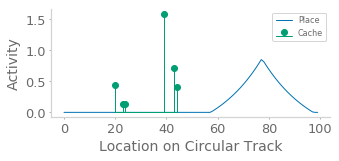

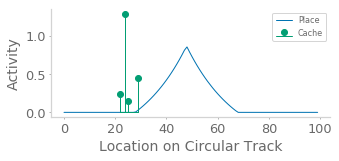

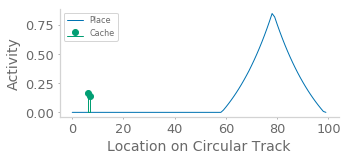

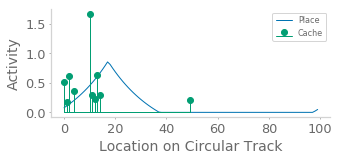

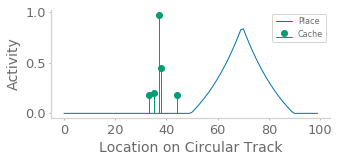

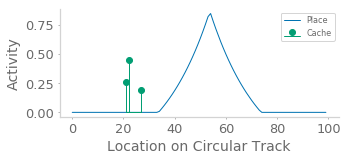

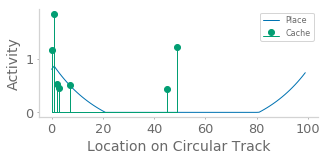

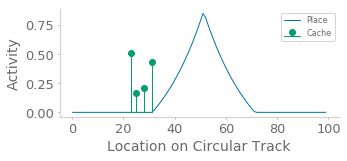

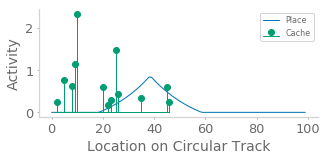

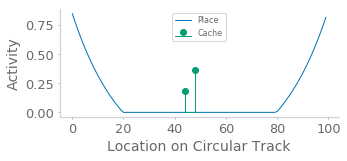

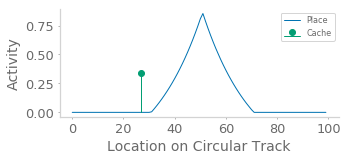

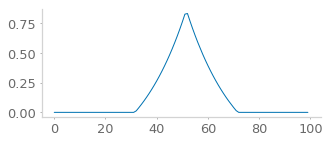

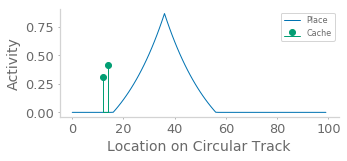

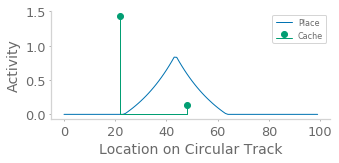

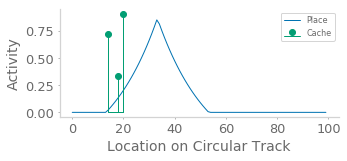

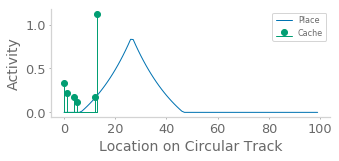

In [28]:
for _ in range(n_samples):
    idx = np.random.choice(N_bar)
    fig, ax = plt.subplots(figsize=(5,2))
    ax.plot(place_acts[:, idx].flatten(), label='Place')
    _cache_acts = avg_cache_acts[:, idx].flatten()
    _cache_acts_x = np.argwhere(_cache_acts>0.1)
    _cache_acts_y = _cache_acts[_cache_acts_x]
    if _cache_acts_x.size==0: continue
    ax.stem(_cache_acts_x, _cache_acts_y, label='Cache',
        linefmt='C2-', markerfmt='C2o', basefmt='C2')
    ax.set_xlabel('Location on Circular Track')
    ax.set_ylabel('Activity')
    plt.legend()
    plt.show()